# :Project Description:

##### Description:
Convolutional Neural Networks (CNNs) are a class of deep learning models particularly suited for processing structured grid-like data, such as images and videos. They are designed to automatically and adaptively learn spatial hierarchies of features through a series of convolutional layers. Each layer consists of filters that convolve over input data, capturing local patterns and features. CNNs are widely used in tasks such as image classification, object detection, and facial recognition due to their ability to effectively handle spatial relationships and hierarchical patterns within data.

##### Data source:
- Kaggle Challenges in Representation Learning: Facial Expression Recognition Challenge: [Link](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge)

##### Authors:
Serah Almeyda, Priya Iragavarapu, Francesca Scipioni, Sowjanya Yaddanapudi, Omar Zu'bi


##### Sources:

# Initializations

In [105]:
# Import dependencies
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout



# Custom user defined imports
from camera_feed import live_feed

# Preliminary Data Investigation

In [66]:
# Import test dataset
path = r'Data\icml_face_data.csv'
df = pd.read_csv(path)

In [67]:
# Column name corrections
df.columns = df.columns.str.lower().str.replace(' ', '')

# Function to convert pixel strings to numpy array
def string_to_array(string):
    '''Split pixles by space value and convert to numpy'''
    return np.array(string.split(), dtype='float32').reshape(48, 48)

# Apply pixel conversions
df['image'] = df['pixels'].apply(string_to_array)

# Get unique emotion classes
emotion_classes = np.sort(df['emotion'].unique())

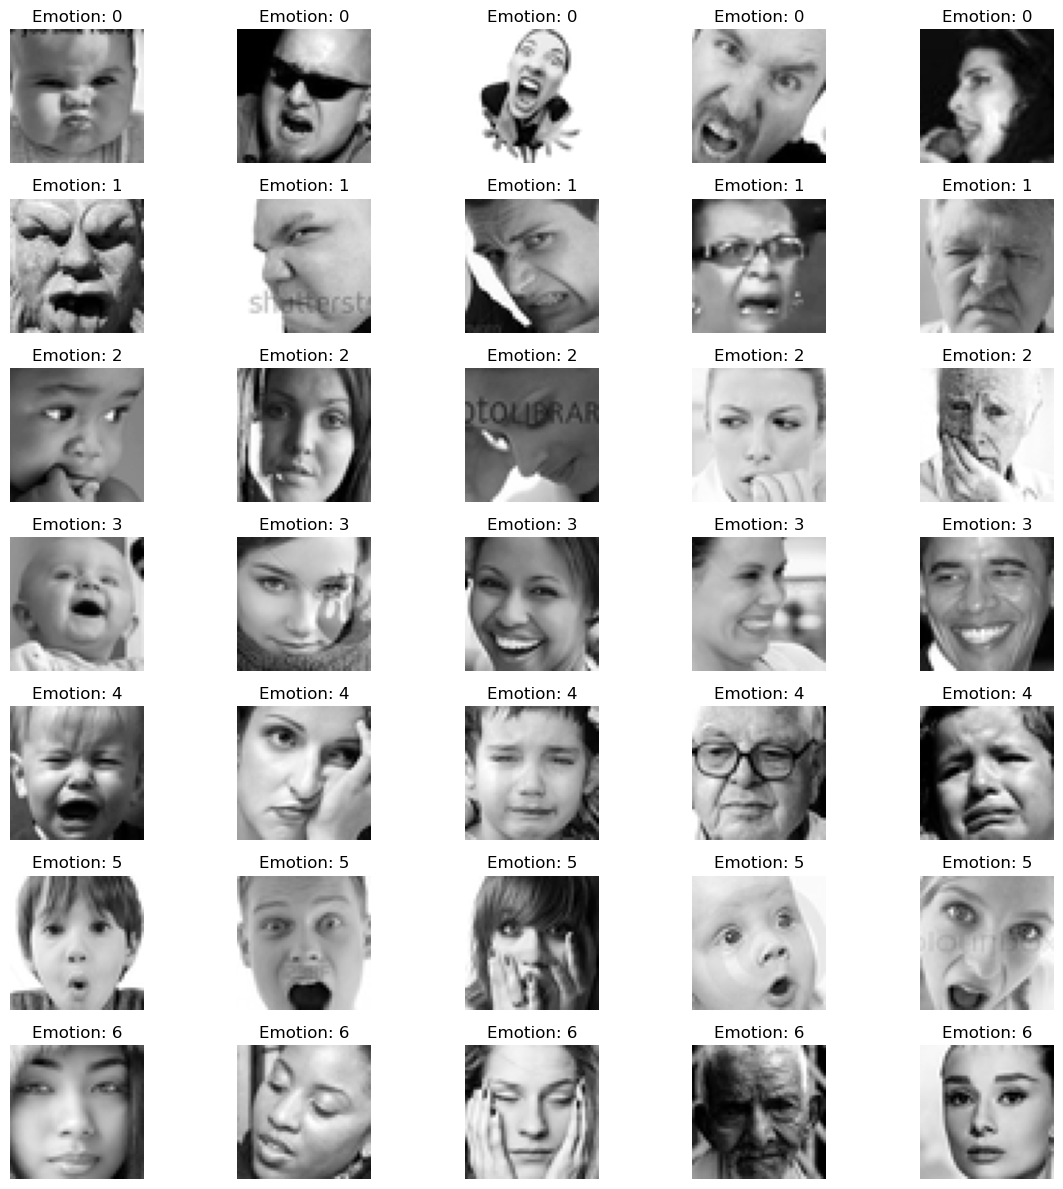

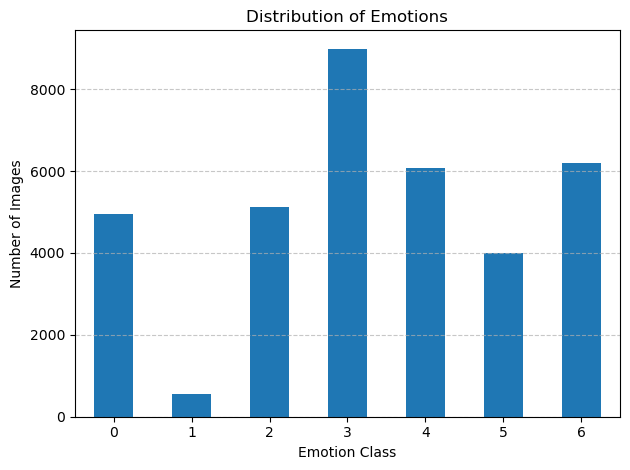

In [80]:
# Plot five images per emotion class
num_images_per_class = 5
fig, axes = plt.subplots(len(emotion_classes), 
                         num_images_per_class, 
                         figsize=(12, 12))

# Specify seed for consistent results
np.random.seed(0)

# Iterate through each emotion class and plot images
for i, emotion_class in enumerate(emotion_classes):
    
    # Select 5 random images from current emotion class
    images = df[df['emotion'] == emotion_class].sample(num_images_per_class)['image'].values
    
    # Image settings
    for j in range(num_images_per_class):
        axes[i, j].imshow(images[j], cmap='gray')
        axes[i, j].set_title(f'Emotion: {emotion_class}')
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

# Plotting the histogram of emotion distribution
plt.figure()
df['emotion'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Notes:
Take note that we have 7 total classes:
- 0=Angry,
- 1=Disgust, 
- 2=Fear, 
- 3=Happy, 
- 4=Sad, 
- 5=Surprise, 
- 6=Neutral

Each image is 48X48 pixel greyscale images of faces. The faces are more/less centered and occupies the same amount of space in each image. The bar graph shows that class 1 has the lowest representation in the training dataset.

Source: https://www.kaggle.com/competitions/challenges-in-representation-learning-facial-expression-recognition-challenge/data

# Model Creation

In [88]:
# Normalize the values in the image column
df['image'] /= 255.0

# Shuffle the dataset
df = df.sample(frac = 1, random_state=42).reset_index(drop=True)

# Specify training datasets
X_train, X_test, y_train, y_test = train_test_split(df['image'].to_numpy(),
                                                    df['emotion'].to_numpy(), test_size=0.2, random_state=42)

# Reshape the X_train and X_test data to (48, 48, 1)
X_train = [i.reshape(48, 48, 1) for i in X_train]
X_test = [i.reshape(48, 48, 1) for i in X_test]

# Esnure numpy array
X_train = np.array(X_train)
X_test = np.array(X_test)

# Print shapes
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (28709, 48, 48, 1)
y_train shape: (28709,)
X_test shape: (7178, 48, 48, 1)
y_test shape: (7178,)


In [19]:
# Create function to define CNN model with default parameters
def create_CNN(n_classes = 10,
               neurons = 128,
               dropout_rate = 0.5,
               num_filters = [32,64,128],
               filter_sizes = [(3,3),(3,3),(3,3)],
               maxpools=[(2, 2), (2, 2), (2, 2)],
               activation = 'relu',
               optimizer = 'adam',
               learning_rate = 0.001,
               metric = ['accuracy'],
               conv_layers = 3,):
    """
    Create a Convolutional Neural Network (CNN) model for image classification (48x48x1).

    Parameters:
    -----------
    n_classes : int
        Number of classes in the classification task.

    neurons : int
        Number of neurons in the fully connected dense layer.

    dropout_rate : float
        Dropout rate to prevent overfitting.

    num_filters : list of int
        List of integers specifying the number of filters for each Conv2D layer.

    filter_sizes : list of tuples
        List of tuples specifying the size of filters (height, width) for each Conv2D layer.

    maxpools : list of tuples
        List of tuples specifying the size of max pooling windows (height, width) for each MaxPooling2D layer.

    activation : str
        Activation function to use in Conv2D and Dense layers.

    optimizer : str or tf.keras.optimizers.Optimizer
        Optimizer to use for training the model.

    learning_rate : float
        Learning rate for the optimizer.

    metrics : list of str
        List of metrics to evaluate during training and testing.

    conv_layers : int
        Number of convolutional layers to include in the CNN architecture.

    Returns:
    --------
    model : tf.keras.models.Sequential
        Compiled CNN model ready for training.
    """
    
    '''Clear session and set seed'''
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    
    # Validate input parameters
    if len(num_filters) != conv_layers or len(filter_sizes) != conv_layers or len(maxpools) != conv_layers:
        raise ValueError("Lengths of num_filters, filter_sizes, and maxpools must match conv_layers.")
    
    '''Build CNN based on user inputs'''
    model = Sequential()
    
    # Go through each layer input
    for i in range(conv_layers):
        # Conv2D Settings
        model.add(Conv2D(num_filters[i], 
                         filter_sizes[i], 
                         activation = activation,
                         input_shape = (48, 48, 1) if i == 0 else None)) # For initial layer only
        
        # MaxPooling settings
        model.add(MaxPooling2D(maxpools[i]))

    # Output layer
    model.add(tf.keras.layers.Flatten()) # Flatten
    model.add(Dense(neurons, activation=activation)) # Train on neurons
    model.add(Dropout(dropout_rate)) # Drop % to prevent overfitting
    model.add(Dense(n_classes, activation='softmax')) # Specify number of outputs

    '''Compile model'''
    model.compile(optimizer = optimizer,
                 loss = 'sparse_categorical_crossentropy',
                 metrics = ['accuracy'])
    
    # Print model summary
    print(model.summary)
    
    # Return statement
    return model

In [11]:
# Create model (Using default settings I've specified)
model = create_CNN()

# Train model for testing purposes
history = model.fit(X_train, y_train,
                   epochs = 20,
                   batch_size = 32,
                   validation_split = 0.4,
                   verbose = 0)

C:\Users\omar_\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


<bound method Model.summary of <Sequential name=sequential, built=True>>


# Live feed demo

In [22]:
# Run live feed model for demonstration purposes
live_feed(model) # Type Q to exit out

# Results Analysis

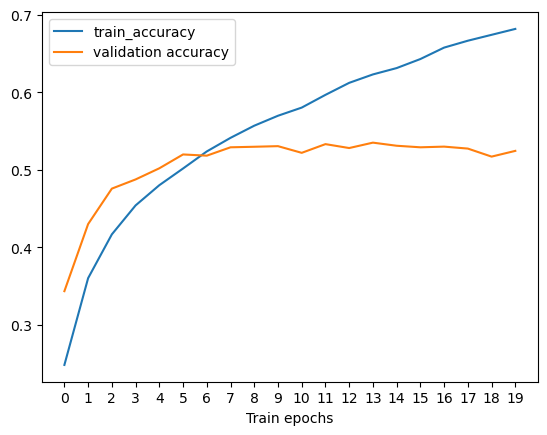

Training accuracy: 0.6817
Validation accuracy: 0.5244
Final training accuracy: 0.1374
Final test accuracy: 0.1403


In [91]:
# Function to calculate model accuracy
def compute_accuracy(model, history, X_train, y_train, X_test, y_test, epochs):
    '''
    Computes the training and validation accuracy after fitting, and evaluates the final testing accuracy.

    Parameters:
    -----------
    model: tf.keras.model
        The CNN model instance created and compiled after fitting.

    history: obj
        The history object returned from model.fit(), containing training metrics.

    X_train: numpy.ndarray
        Training dataset input.

    y_train: numpy.ndarray
        Training dataset labels.

    X_test: numpy.ndarray
        Testing dataset input.

    y_test: numpy.ndarray
        Testing dataset labels.

    epochs: int
        Number of epochs the model was trained for.
    ''' 
    
    # Get training and valudation accuracy of digits model
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    plt.plot(train_accuracy, label='train_accuracy')
    plt.plot(val_accuracy, label='validation accuracy')
    plt.xticks(range(epochs))
    plt.xlabel('Train epochs')
    plt.legend()
    plt.show()

    print('Training accuracy: %1.4f' % train_accuracy[-1])
    print('Validation accuracy: %1.4f' % val_accuracy[-1])

    # Evaluate the model on train and test datasets
    train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

    print('Final training accuracy: %1.4f' % train_acc)
    print('Final test accuracy: %1.4f' % test_acc)
    
# Comptue model accuracies
compute_accuracy(model, history, X_train, y_train , X_test, y_test, 20)


In [113]:
y_test

array([5, 6, 6, ..., 4, 6, 4], dtype=int64)

In [114]:
test_preds_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


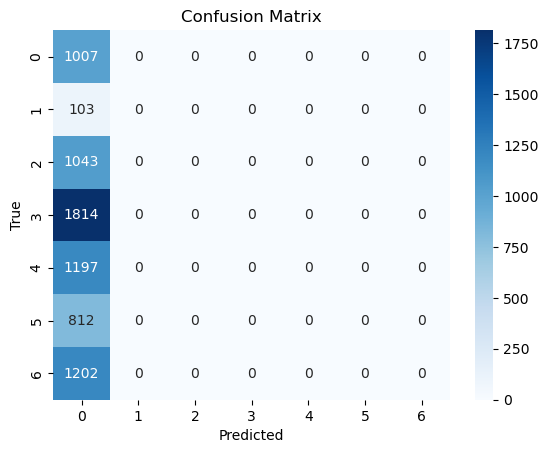

In [111]:
# Get testing dataset predictions and labels
test_preds = model.predict(X_test)
test_preds_labels = np.argmax(test_preds, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, test_preds_labels)

# Plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=[0,1,2,3,4,5,6], yticklabels=[0,1,2,3,4,5,6])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Next steps

1) create looping function to test combo of model parameters and fitting parameters and select min loss.
2) revist transforming the raw data during preprocessing phase
3) compile analysis of test results
4) further data investigation process (checkout CNN and NN hws). 